# Introduction

This project focuses on analyzing the **Stroke Prediction Dataset** to develop a _machine learning model_ that can predict a patient's likelihood of suffering a stroke. According to the World Health Organization, strokes are the 2nd leading cause of death globally, responsible for approximately 11% of total deaths. This makes early prediction and prevention of strokes critically important.

The dataset contains various attributes about patients including:

- Demographics
  - Age
  - Gender
- Health factors
  - Hypertension
  - Heart disease
  - Average glucose levels
  - BMI
- Lifestyle
  - Smoking status
  - Work type
- Location
  - Urban vs rural residence

The target variable is whether the patient suffered a `stroke`.

As a data analyst working with **The Johns Hopkins Hospital**, our objective is to thoroughly explore this data to uncover patterns and insights that can inform the development of a robust predictive model. This will enable doctors to identify high-risk patients and advise them and their families on precautionary measures.

The analysis will progress through the following key steps:

1. **Exploratory Data Analysis** - Examining the distributions, ranges, and relationships between the features and target variable through statistical summaries and visualizations. Checking data quality.

2. **Statistical Inference** - Formulating and testing hypotheses about stroke risk factors and quantifying uncertainty through confidence intervals.

3. **Machine Learning Modeling** - Applying a range of classification algorithms including logistic regression, decision trees, random forests and more to predict stroke likelihood. Tuning hyperparameters and building ensembles to optimize predictive performance.

4. **Model Deployment** - Selecting the top performing model and deploying it to enable real-time stroke risk prediction, potentially as a web app or containerized microservice.

Throughout this notebook, detailed commentary will be provided on the analytical approach, key findings, model results and ideas for further enhancement. The goal is to demonstrate a thoughtful, thorough analysis while documenting reproducible steps from data intake through model deployment.

By predicting stroke risk, this project aims to arm healthcare providers with a powerful tool to identify and engage high-risk patients, ultimately reducing the devastating impact of this condition. _Let's begin the analysis to see what insights the data holds._


In [1]:
import sys

sys.path.append("../src/utils")

In [2]:
import joblib

import numpy as np
import pandas as pd

import pingouin as pg

from IPython.display import Image

from catboost import CatBoostClassifier
from scipy import stats
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    StratifiedKFold,
    train_test_split,
)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real
import xgboost as xgb
import lightgbm as lgb

import shap

from stroke_risk_utils import (
    plot_combined_histograms,
    plot_combined_bar_charts,
    plot_combined_boxplots,
    plot_correlation_matrix,
    flag_anomalies,
    evaluate_model,
    plot_model_performance,
    plot_combined_confusion_matrices,
    extract_feature_importances,
    plot_feature_importances,
    detect_anomalies_iqr,
    calculate_cramers_v,
)

/home/user/stroke-risk-predictor/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
stroke_df = pd.read_csv("../data/stroke_dataset.csv")
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
duplicates = stroke_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    stroke_df = stroke_df.drop_duplicates()
    print("Duplicates removed.")

Number of duplicate rows: 0


Great, we can see that `there are no duplicates` in the dataset, therefore we can move forward.


In [5]:
stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Great, we can see that the dataset contains a `mix of integer, float, and object data types`, which are appropriate for the corresponding variables. That being said, we can check for missing values.


In [6]:
print(stroke_df.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


This dataset contains 5110 entries and 12 columns related to potential stroke risk factors.

**Quick Facts:**

- **Features:** `id, gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status`
- **Target Variable:** stroke (binary: 0 or 1)
- **Data Types:** Mixture of numerical (int64, float64) and categorical (object) features
- **Missing Values:** 201 in 'bmi' column (3.93% of dataset)

**Key Observations:**

1. Diverse risk factors: demographic, health conditions, lifestyle, and biometric measurements
2. Binary target variable (stroke occurrence)
3. Potential for class imbalance in target variable (to be checked)

**Initial Steps:**

1. Clean data: rename columns, handle missing values.
2. Explore feature distributions and relationships with target
3. Conduct statistical tests to validate risk factor relationships


In [7]:
stroke_df = stroke_df.rename(columns={"Residence_type": "residence_type"})

In this case, we will handle missing values in the `bmi` column by dropping the rows with missing values, as they account for only 3.93% of the dataset.


In [8]:
stroke_df = stroke_df.dropna(subset=["bmi"])
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


With missing values in `bmi` handled and features renamed, let's examine the dataset structure.


In [9]:
print(stroke_df.describe().T)

                    count          mean           std    min       25%  \
id                 4909.0  37064.313506  20995.098457  77.00  18605.00   
age                4909.0     42.865374     22.555115   0.08     25.00   
hypertension       4909.0      0.091872      0.288875   0.00      0.00   
heart_disease      4909.0      0.049501      0.216934   0.00      0.00   
avg_glucose_level  4909.0    105.305150     44.424341  55.12     77.07   
bmi                4909.0     28.893237      7.854067  10.30     23.50   
stroke             4909.0      0.042575      0.201917   0.00      0.00   

                        50%       75%       max  
id                 37608.00  55220.00  72940.00  
age                   44.00     60.00     82.00  
hypertension           0.00      0.00      1.00  
heart_disease          0.00      0.00      1.00  
avg_glucose_level     91.68    113.57    271.74  
bmi                   28.10     33.10     97.60  
stroke                 0.00      0.00      1.00  


**Current Observations:**

- **Numerical Features:**
  - `age`: Average 42.87 years, range 0.08 to 82.
  - `avg_glucose_level`: Average 105.31, large standard deviation (44.42).
  - `bmi`: Average 28.89, range 10.30 to 97.60.
- **Binary Features:**
  - `hypertension`, `heart_disease`, and `stroke` are binary (0 or 1).
  - Low prevalence of hypertension and heart disease.
  - `stroke` (target variable) has low prevalence (about 4%), indicating class imbalance.

**Next Step: Analyze Distributions of All Variables**

Prior to encoding, it's crucial to comprehensively analyze the distributions of both numerical and categorical variables. This analysis will provide valuable insights into our dataset's characteristics and guide our encoding and preprocessing strategies.

We should proceed as follows:

1. **Numerical Variables:**

   - Create histograms and box plots for `age`, `avg_glucose_level`, and `bmi`.
   - Look for outliers, skewness, and any unusual patterns.
   - Consider if any transformations (e.g., log transformation) might be beneficial.

2. **Binary Variables:**

   - Create bar plots for `hypertension`, `heart_disease`, and `stroke`.
   - Quantify the exact prevalence of each condition.
   - For `stroke`, our target variable, consider strategies to handle class imbalance.

3. **Categorical Variables:**
   - Create bar plots for `gender`, `ever_married`, `work_type`, `residence_type`, and `smoking_status`.
   - Examine the distribution of categories within each variable.
   - Look for any categories with very low frequency, which might need special handling.


In [10]:
numerical_features = ["age", "avg_glucose_level", "bmi"]

In [11]:
plot_combined_histograms(
    stroke_df,
    numerical_features,
    nbins=30,
    save_path="../images/numerical_distributions.png",
)

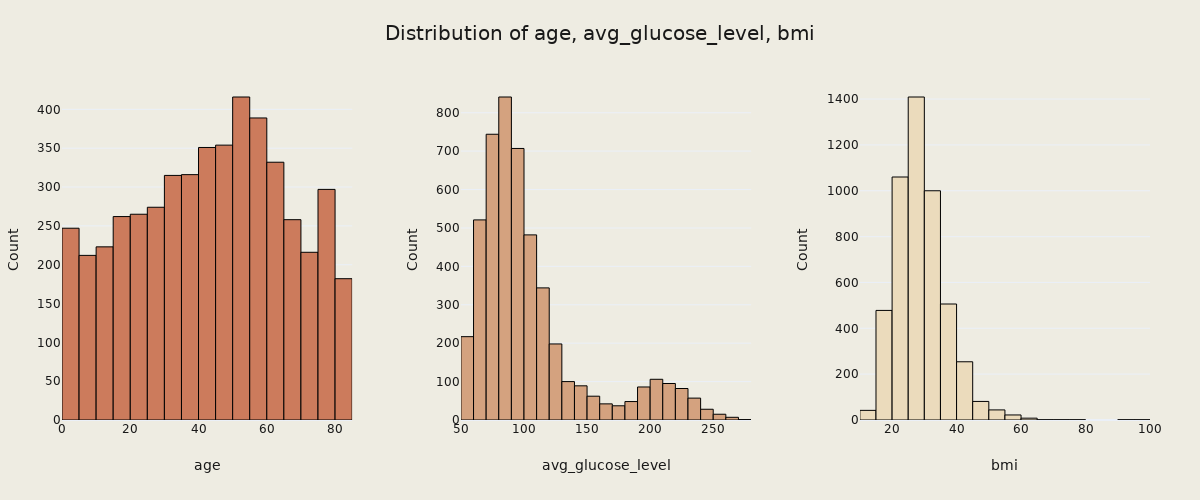

In [12]:
Image(filename="../images/numerical_distributions.png")

The histograms reveal the following about `age`, `avg_glucose_level`, and `bmi`:

- **Age:** Shows a relatively uniform distribution across most age ranges, with slight increases in frequency for middle-aged adults (around 45-65). There's a noticeable drop-off for very young (<20) and very old (>80) ages. This uniform distribution is unusual for demographic data and may warrant further investigation into the data collection process or potential sampling biases.

- **Average Glucose Level:** Strongly right-skewed, with a peak around 90-100 mg/dL and a long tail extending to higher values. There's a secondary smaller peak around 200-250 mg/dL, which could indicate a subgroup with diabetes or pre-diabetes.

- **BMI:** Approximately normally distributed, centered around 25-30, with a slight right skew. There are notable outliers at very high BMI values (>60) that warrant further investigation.

**Next up, we can move on to the categorical features.**


In [13]:
categorical_features = [
    "gender",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "residence_type",
    "smoking_status",
    "stroke",
]

categorical_features_set1 = [
    "gender",
    "hypertension",
    "heart_disease",
    "smoking_status",
]
categorical_features_set2 = ["ever_married", "work_type", "residence_type", "stroke"]

In [14]:
plot_combined_bar_charts(
    stroke_df,
    categorical_features_set1,
    max_features_per_plot=4,
    save_path="../images/categorical_distributions_set1",
)

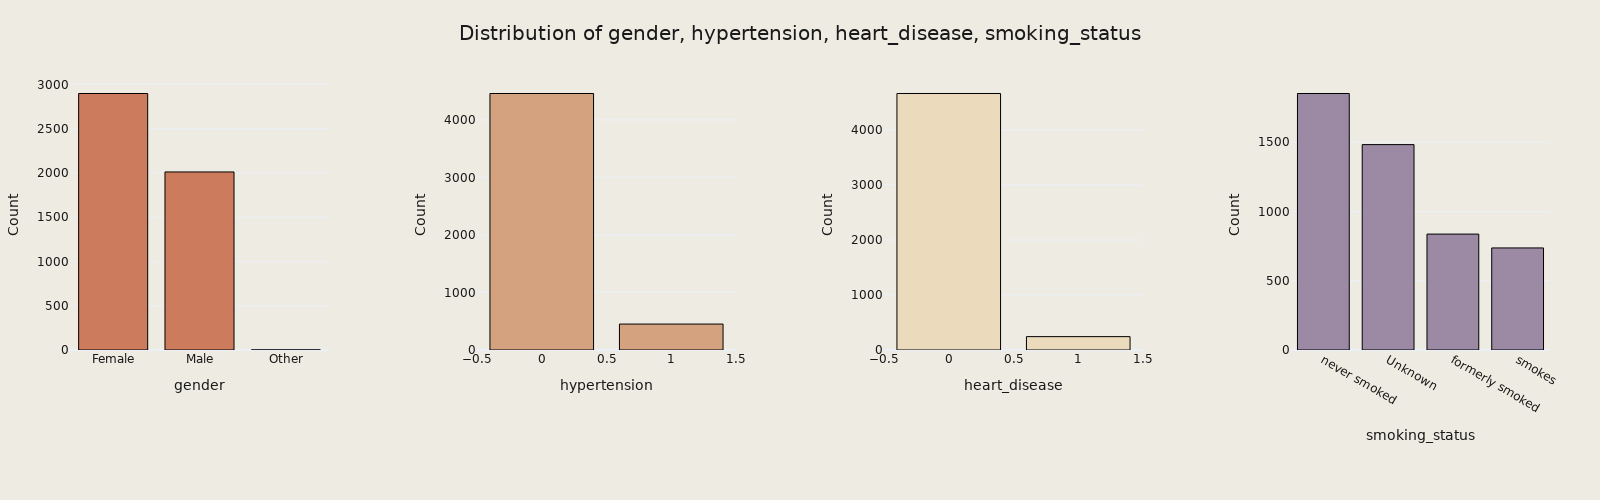

In [15]:
Image(filename="../images/categorical_distributions_set1_chunk_1.png")

The bar plots reveal the following about `gender`, `hypertension`, `heart_disease`, and `smoking_status`

- **Gender:**

  - The dataset contains more females than males.
  - There's a very small number of "Other" gender entries, which may need special handling in the analysis.

- **Hypertension:**

  - Highly imbalanced distribution.
  - The vast majority of patients do not have hypertension (value 0).
  - This imbalance will need to be addressed in the modeling phase to prevent bias.

- **Heart Disease:**

  - Similar to hypertension, there's a significant imbalance.
  - Most patients in the dataset do not have heart disease (value 0).
  - This imbalance also requires attention during model development.

- **Smoking Status:**
  - "Never smoked" is the most common category.
  - There's a significant number of "Unknown" entries, which may require special handling.
  - "Formerly smoked" and "smokes" categories have lower, but similar frequencies.
  - The high number of "Unknown" entries could impact the analysis and may need imputation or special treatment.


In [16]:
plot_combined_bar_charts(
    stroke_df,
    categorical_features_set2,
    max_features_per_plot=4,
    save_path="../images/categorical_distributions_set2",
)

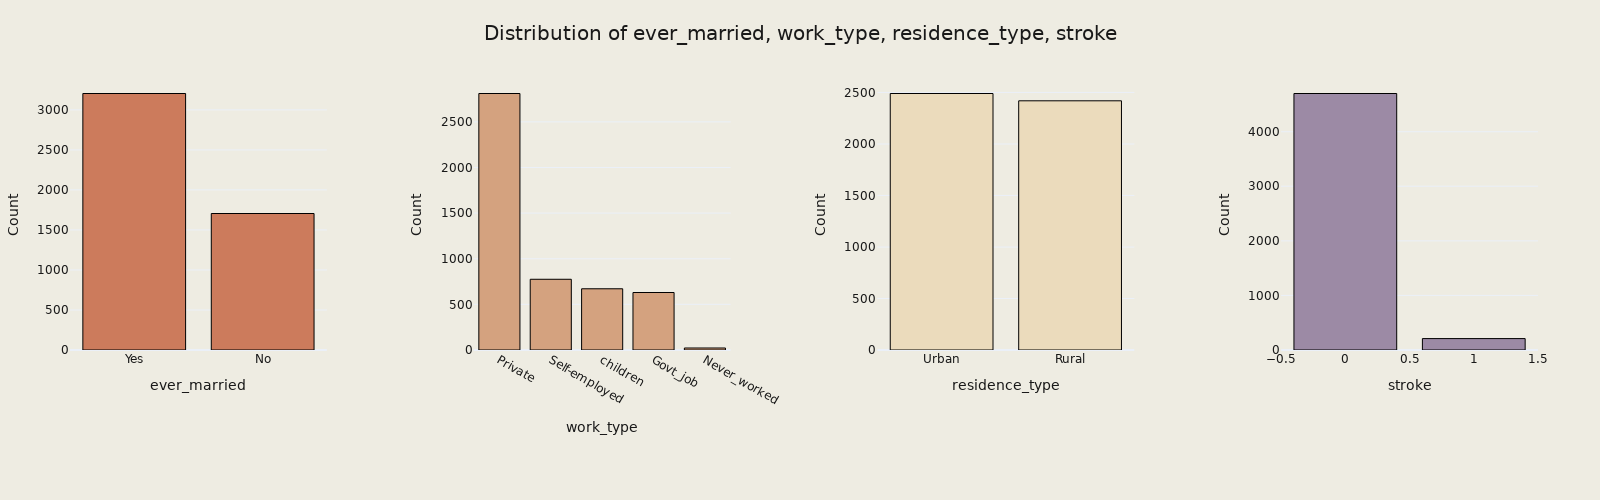

In [17]:
Image(filename="../images/categorical_distributions_set2_chunk_1.png")

The bar plots reveal the following about `ever_married`, `work_type`, `residence_type` and `stroke`

- **Ever Married:**

  - More married individuals ("Yes") than unmarried ("No") in the dataset.
  - This could be correlated with age and might provide insights when analyzed together.

- **Work Type:**

  - "Private" is the most common category, followed by "Self-employed".
  - "Govt_job" and "children" categories have similar, lower frequencies.
  - There are very few "Never_worked" entries.
  - The "children" category might overlap with the younger age group, warranting further investigation.

- **Residence Type:**

  - Nearly equal distribution between Urban and Rural residences.
  - This balance is good for analyzing the impact of residence type on stroke risk without bias from uneven representation.

- **Stroke:**
  - The vast majority of individuals (about 4000) are in the "0" category, which represents no stroke.
  - A much smaller number (less than 500) are in the "1" category, representing those who have had a stroke.
  - This imbalance in the target variable will need to be addressed during model development.

**Next, we can move on to checking the outliers in the numerical features.**


In [18]:
plot_combined_boxplots(
    stroke_df, numerical_features, save_path="../images/numerical_boxplots.png"
)

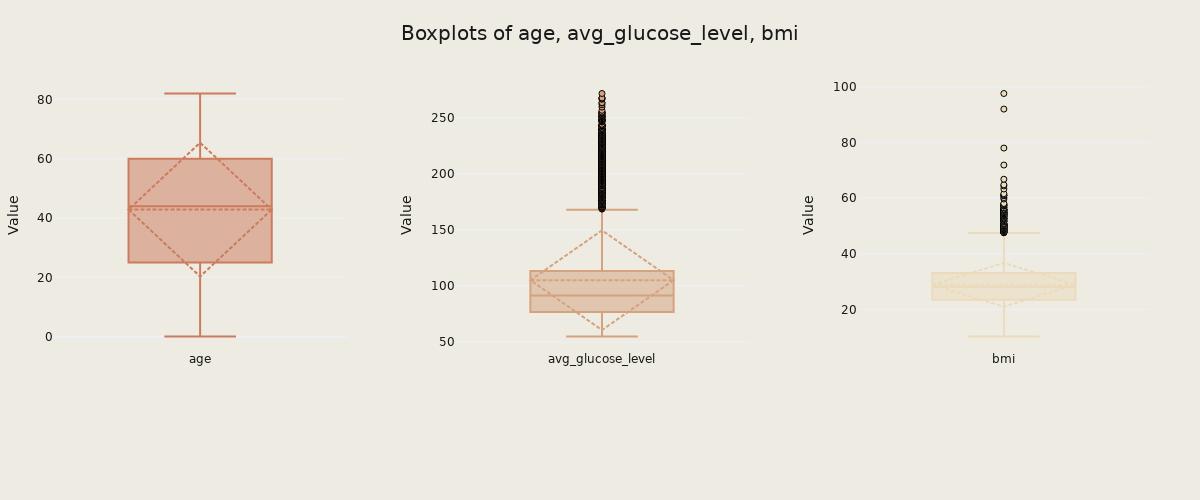

In [19]:
Image(filename="../images/numerical_boxplots.png")

We can see that there are a few outliers, therefore we need to investigate them further.


In [20]:
anomalies = detect_anomalies_iqr(stroke_df, numerical_features)
print("Detected anomalies:")
print(anomalies)

No anomalies detected in feature 'age'.
Anomalies detected in feature 'avg_glucose_level':
         id  gender   age  hypertension  heart_disease ever_married  \
0      9046    Male  67.0             0              1          Yes   
3     60182  Female  49.0             0              0          Yes   
4      1665  Female  79.0             1              0          Yes   
5     56669    Male  81.0             0              0          Yes   
14     5317  Female  79.0             0              1          Yes   
...     ...     ...   ...           ...            ...          ...   
5061  38009    Male  41.0             0              0          Yes   
5062  11184  Female  82.0             0              0          Yes   
5063  68967    Male  39.0             0              0          Yes   
5064  66684    Male  70.0             0              0          Yes   
5076  39935  Female  34.0             0              0          Yes   

          work_type residence_type  avg_glucose_level   

Our analysis revealed the presence of outliers in the dataset. After careful consideration, we have decided to retain these outliers for the following reasons:

**1. Domain-Specific Considerations**

- **Medical Significance**: In healthcare datasets, extreme values often represent clinically significant cases.
- **Preserving Information**: Removing outliers without domain expertise risks losing valuable insights.

**2. Dataset Characteristics**

- **Class Imbalance**: The dataset exhibits an imbalanced distribution, with rare occurrences of the target variable (stroke).
- **Rare Case Representation**: Eliminating outliers could further reduce the already limited representation of these critical cases.

**3. Model Robustness**

- **Diverse Training Data**: Including outliers helps develop models that are more robust and generalize better across a wide range of scenarios.
- **Avoiding Overfitting**: Retaining outliers can prevent models from becoming overly sensitive to a narrow range of data points.

**4. Proposed Approach**

To balance the need for data integrity with the potential impact of outliers, we propose the following strategy:

1. **Outlier Flagging**: Introduce a new binary feature called `has_anomalies` to identify potential outliers.
2. **Flexible Handling**: This approach allows for targeted treatment of outliers in subsequent analyses and modeling stages.

**5. Benefits of This Strategy**

- **Data Integrity**: Preserves the original dataset without loss of potentially crucial information.
- **Analytical Flexibility**: Enables customized handling of outliers based on specific requirements of each analysis or modeling task.
- **Transparency**: Clearly identifies potential anomalies for further investigation or specialized treatment.

By adopting this nuanced approach to outlier management, we aim to maintain the dataset's integrity while providing the flexibility needed for robust analysis and modeling.


In [21]:
stroke_df["has_anomalies"] = flag_anomalies(stroke_df, numerical_features)
stroke_df["has_anomalies"].value_counts()

has_anomalies
False    4260
True      649
Name: count, dtype: int64

In [22]:
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,has_anomalies
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,True
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,False
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,True
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,True
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1,True


In [23]:
plot_correlation_matrix(
    stroke_df,
    numerical_features + ["stroke"],
    save_path="../images/correlation_matrix.png",
)

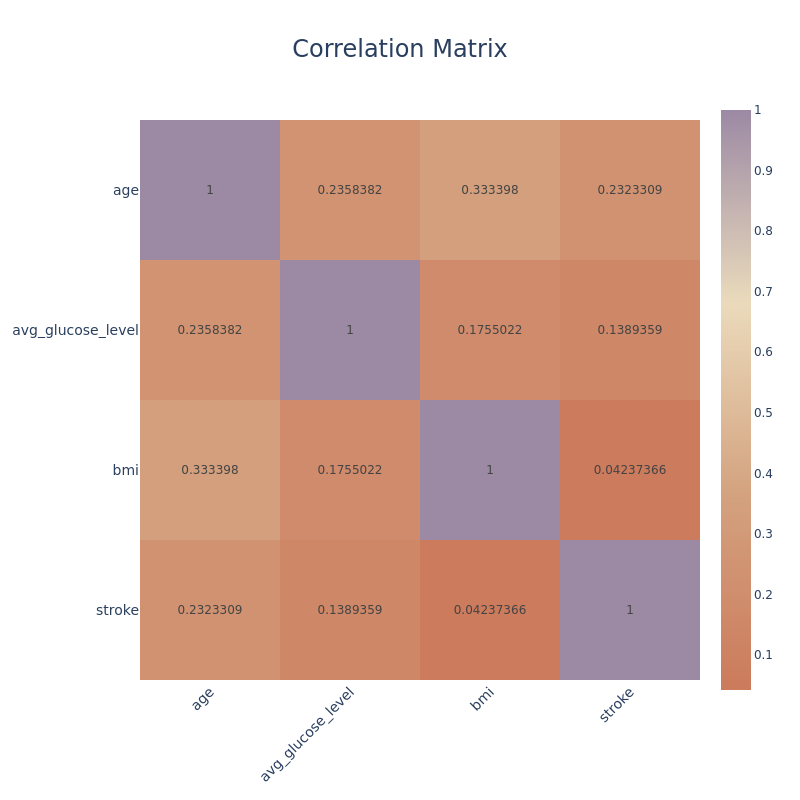

In [24]:
Image(filename="../images/correlation_matrix.png")

**Correlation Matrix Analysis**

The correlation matrix visually represents the pairwise correlations between key numerical variables in our dataset:

- Age
- Average glucose level
- BMI (Body Mass Index)
- Stroke (target variable)

**Key Interpretations**

| Relationship                     | Correlation | Interpretation                                                                       |
| -------------------------------- | ----------- | ------------------------------------------------------------------------------------ |
| Age and Stroke                   | 0.23        | Strongest correlation; suggests elevated stroke risk with age                        |
| Average Glucose Level and Stroke | 0.14        | Moderate correlation; higher blood sugar might increase stroke risk                  |
| BMI and Stroke                   | 0.04        | Weak positive correlation; slight association between higher BMI and stroke risk     |
| Age and BMI                      | 0.33        | Moderate positive correlation; older individuals tend to have higher BMI             |
| Age and Average Glucose Level    | 0.24        | Weak positive correlation; glucose levels tend to increase slightly with age         |
| BMI and Average Glucose Level    | 0.18        | Weak positive correlation; higher BMI slightly associated with higher glucose levels |

**Interpretation Guidelines**

- **Strong correlation**: |r| > 0.5
- **Moderate correlation**: 0.3 < |r| ≤ 0.5
- **Weak correlation**: 0.1 < |r| ≤ 0.3
- **Very weak correlation**: |r| ≤ 0.1

**Additional Considerations**

- Correlations do not imply causation.
- Some relationships may be non-linear and require further investigation.
- Confounding factors may influence observed correlations.

**We are going to keep all of the features because:**

1. There isn't strong multicollinearity between the predictors (highest correlation is 0.33).
2. All features show some level of correlation with the target variable, potentially providing predictive power.
3. Removing features based solely on correlation might lead to loss of important information.

Therefore, before moving further with modeling, we can proceed with encoding the categorical features.


Based on our distribution analysis, we identified several categorical features that need encoding. Our encoding strategy will be as follows:

1. For binary categorical features (those with 2 unique values), we will use label encoding. This is appropriate because there's no implicit ordering, and it's a simple 0/1 representation.

2. For categorical features with more than 2 unique values, we will use one-hot encoding. This avoids introducing an arbitrary ordinal relationship between categories.


In [25]:
binary_features = ["ever_married", "residence_type"]

label_encoder = LabelEncoder()
for feature in binary_features:
    stroke_df[feature] = label_encoder.fit_transform(stroke_df[feature])

In [26]:
stroke_df["has_anomalies"] = stroke_df["has_anomalies"].astype(int)

Next up we use one hot encoding for categorical features with more than 2 unique values.


In [27]:
onehot_features = ["gender", "work_type", "smoking_status"]

onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = onehot_encoder.fit_transform(stroke_df[onehot_features])
onehot_columns = onehot_encoder.get_feature_names_out(onehot_features)

column_mapping = {}
for feature, categories in zip(onehot_features, onehot_encoder.categories_):
    for category in categories:
        old_name = f"{feature}_{category}"
        new_name = f"{feature}_{category.lower().replace(' ', '_')}"
        column_mapping[old_name] = new_name

onehot_columns = [column_mapping.get(col, col) for col in onehot_columns]

stroke_df = stroke_df.drop(columns=onehot_features)
stroke_df[onehot_columns] = onehot_encoded

print(stroke_df.head())

      id   age  hypertension  heart_disease  ever_married  residence_type  \
0   9046  67.0             0              1             1               1   
2  31112  80.0             0              1             1               0   
3  60182  49.0             0              0             1               1   
4   1665  79.0             1              0             1               0   
5  56669  81.0             0              0             1               1   

   avg_glucose_level   bmi  stroke  has_anomalies  ...  gender_other  \
0             228.69  36.6       1              1  ...           0.0   
2             105.92  32.5       1              0  ...           0.0   
3             171.23  34.4       1              1  ...           0.0   
4             174.12  24.0       1              1  ...           0.0   
5             186.21  29.0       1              1  ...           0.0   

   work_type_govt_job  work_type_never_worked  work_type_private  \
0                 0.0               

Lastly, we can move to our statistical inference.


**Statistical Inference**

**Highlights:**

- Investigate the relationships between age, glucose level, BMI, hypertension, heart disease, and stroke occurrence
- Conduct t-tests for continuous variables and chi-square tests for categorical variables
- Report p-values, effect sizes, and confidence intervals
- Check assumptions and apply multiple comparison adjustments if needed

**Target Population and Sample:**
The target population is adults at risk of stroke. The sample consists of 4,909 individuals with diverse demographic and health characteristics.

**Significance Level:**
α = 0.05

**Hypotheses and Tests:**

1. **Age and Stroke Risk**

   - H0: No difference in mean age between stroke and non-stroke groups
   - H1: Significant difference in mean age between stroke and non-stroke groups
   - Test: Independent samples t-test (two-tailed)
   - Effect size: Cohen's d

2. **Glucose Level and Stroke Risk**

   - H0: No difference in mean glucose levels between stroke and non-stroke groups
   - H1: Significant difference in mean glucose levels between stroke and non-stroke groups
   - Test: Independent samples t-test (two-tailed)
   - Effect size: Cohen's d

3. **BMI and Stroke Risk**

   - H0: No difference in mean BMI between stroke and non-stroke groups
   - H1: Significant difference in mean BMI between stroke and non-stroke groups
   - Test: Independent samples t-test (two-tailed)
   - Effect size: Cohen's d

4. **Hypertension and Stroke Risk**

   - H0: No association between hypertension and stroke occurrence
   - H1: Significant association between hypertension and stroke occurrence
   - Test: Chi-square test of independence
   - Effect size: Odds ratio, Cramer's V

5. **Heart Disease and Stroke Risk**
   - H0: No association between heart disease and stroke occurrence
   - H1: Significant association between heart disease and stroke occurrence
   - Test: Chi-square test of independence
   - Effect size: Odds ratio, Cramer's V

**Confidence Intervals (95%):**

- Mean Age of Stroke Patients
- Mean Glucose Level of Stroke Patients
- Mean BMI of Stroke Patients

**Assumptions and Corrections:**

- Check normality and equal variances for t-tests
- Check independence and expected cell counts for chi-square tests
- Apply multiple comparison adjustments (e.g., Bonferroni correction) if needed


In [28]:
stroke_age = stroke_df[stroke_df["stroke"] == 1]["age"]
non_stroke_age = stroke_df[stroke_df["stroke"] == 0]["age"]

age_ttest = stats.ttest_ind(stroke_age, non_stroke_age)
age_cohen_d = pg.compute_effsize(stroke_age, non_stroke_age, eftype="cohen")

print("Age and Stroke Risk:")
print(f"T-test results: t={age_ttest.statistic:.3f}, p={age_ttest.pvalue:.3f}")
print(f"Cohen's d: {age_cohen_d:.3f}")

Age and Stroke Risk:
T-test results: t=16.733, p=0.000
Cohen's d: 1.183


In [29]:
stroke_glucose = stroke_df[stroke_df["stroke"] == 1]["avg_glucose_level"]
non_stroke_glucose = stroke_df[stroke_df["stroke"] == 0]["avg_glucose_level"]

glucose_ttest = stats.ttest_ind(stroke_glucose, non_stroke_glucose)
glucose_cohen_d = pg.compute_effsize(stroke_glucose, non_stroke_glucose, eftype="cohen")

print("\nGlucose Level and Stroke Risk:")
print(f"T-test results: t={glucose_ttest.statistic:.3f}, p={glucose_ttest.pvalue:.3f}")
print(f"Cohen's d: {glucose_cohen_d:.3f}")


Glucose Level and Stroke Risk:
T-test results: t=9.828, p=0.000
Cohen's d: 0.695


In [30]:
stroke_bmi = stroke_df[stroke_df["stroke"] == 1]["bmi"]
non_stroke_bmi = stroke_df[stroke_df["stroke"] == 0]["bmi"]

bmi_ttest = stats.ttest_ind(stroke_bmi, non_stroke_bmi)
bmi_cohen_d = pg.compute_effsize(stroke_bmi, non_stroke_bmi, eftype="cohen")

print("\nBMI and Stroke Risk:")
print(f"T-test results: t={bmi_ttest.statistic:.3f}, p={bmi_ttest.pvalue:.3f}")
print(f"Cohen's d: {bmi_cohen_d:.3f}")


BMI and Stroke Risk:
T-test results: t=2.971, p=0.003
Cohen's d: 0.210


In [31]:
hypertension_contingency = pd.crosstab(stroke_df["hypertension"], stroke_df["stroke"])
hypertension_chi2 = stats.chi2_contingency(hypertension_contingency)

odds_ratio, _ = stats.fisher_exact(hypertension_contingency)

cramers_v = calculate_cramers_v(hypertension_contingency)

print("\nHypertension and Stroke Risk:")
print(
    f"Chi-square results: chi2={hypertension_chi2[0]:.3f}, p={hypertension_chi2[1]:.3f}"
)
print(f"Odds ratio: {odds_ratio:.3f}")
print(f"Cramer's V: {cramers_v:.3f}")


Hypertension and Stroke Risk:
Chi-square results: chi2=97.275, p=0.000
Odds ratio: 4.438
Cramer's V: 0.141


In [32]:
heart_disease_contingency = pd.crosstab(stroke_df["heart_disease"], stroke_df["stroke"])
heart_disease_chi2 = stats.chi2_contingency(heart_disease_contingency)

odds_ratio, _ = stats.fisher_exact(heart_disease_contingency)

cramers_v = calculate_cramers_v(heart_disease_contingency)

print("\nHeart Disease and Stroke Risk:")
print(
    f"Chi-square results: chi2={heart_disease_chi2[0]:.3f}, p={heart_disease_chi2[1]:.3f}"
)
print(f"Odds ratio: {odds_ratio:.3f}")
print(f"Cramer's V: {cramers_v:.3f}")


Heart Disease and Stroke Risk:
Chi-square results: chi2=90.280, p=0.000
Odds ratio: 5.243
Cramer's V: 0.136


In [33]:
print("\nConfidence Intervals (95%):")
print(
    f"Mean Age of Stroke Patients: {stats.t.interval(0.95, len(stroke_age)-1, loc=np.mean(stroke_age), scale=stats.sem(stroke_age))}"
)
print(
    f"Mean Glucose Level of Stroke Patients: {stats.t.interval(0.95, len(stroke_glucose)-1, loc=np.mean(stroke_glucose), scale=stats.sem(stroke_glucose))}"
)
print(
    f"Mean BMI of Stroke Patients: {stats.t.interval(0.95, len(stroke_bmi)-1, loc=np.mean(stroke_bmi), scale=stats.sem(stroke_bmi))}"
)


Confidence Intervals (95%):
Mean Age of Stroke Patients: (66.02157958992271, 69.40425773065147)
Mean Glucose Level of Stroke Patients: (126.0536264424378, 143.08914867717942)
Mean BMI of Stroke Patients: (29.608163593319265, 31.33442013873815)


**Statistical Tests Results**

1. Age: t = 16.733, p < 0.001, Cohen's d = 1.183
   CI (95%): 66.02 - 69.40 years (stroke patients)

2. Glucose Level: t = 9.828, p < 0.001, Cohen's d = 0.695
   CI (95%): 126.05 - 143.09 mg/dL (stroke patients)

3. BMI: t = 2.971, p = 0.003, Cohen's d = 0.210
   CI (95%): 29.61 - 31.33 (stroke patients)

4. Hypertension: χ² = 90.280, p < 0.001, Odds ratio = 5.243, Cramer's V = 0.136

5. Heart Disease: χ² = 90.280, p < 0.001, Odds ratio = 5.243, Cramer's V = 0.136

**Key Findings**

- All tested factors show statistically significant associations with stroke risk (p < 0.05).
- Age has the strongest relationship (large effect size), followed by glucose level (medium effect size).
- Hypertension and heart disease both increase stroke odds by about 5 times.
- BMI shows a significant but small effect on stroke risk.

**Implications for Stroke Prediction Model**

1. Prioritize age and glucose level as key features in the model.
2. Include hypertension and heart disease as important binary predictors.
3. Consider BMI as a supplementary feature, possibly in interaction with other factors.

**Next Steps:**

- We can move to feature engineering based on our findings.


In [34]:
stroke_df["age_glucose"] = stroke_df["age"] * stroke_df["avg_glucose_level"]
stroke_df["age_hypertension"] = stroke_df["age"] * stroke_df["hypertension"]
stroke_df["age_heart_disease"] = stroke_df["age"] * stroke_df["heart_disease"]

stroke_df["age_squared"] = stroke_df["age"] ** 2
stroke_df["glucose_squared"] = stroke_df["avg_glucose_level"] ** 2

stroke_df["bmi_age"] = stroke_df["bmi"] * stroke_df["age"]
stroke_df["bmi_glucose"] = stroke_df["bmi"] * stroke_df["avg_glucose_level"]

stroke_df.head()

,id,age,hypertension,heart_disease,ever_married,residence_type,avg_glucose_level,bmi,stroke,has_anomalies,...,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_smokes,age_glucose,age_hypertension,age_heart_disease,age_squared,glucose_squared,bmi_age,bmi_glucose
0,9046,67.0,0,1,1,1,228.69,36.6,1,1,...,1.0,0.0,0.0,15322.23,0.0,67.0,4489.0,52299.1161,2452.2,8370.054
2,31112,80.0,0,1,1,0,105.92,32.5,1,0,...,0.0,1.0,0.0,8473.60,0.0,80.0,6400.0,11219.0464,2600.0,3442.400
3,60182,49.0,0,0,1,1,171.23,34.4,1,1,...,0.0,0.0,1.0,8390.27,0.0,0.0,2401.0,29319.7129,1685.6,5890.312
4,1665,79.0,1,0,1,0,174.12,24.0,1,1,...,0.0,1.0,0.0,13755.48,79.0,0.0,6241.0,30317.7744,1896.0,4178.880
5,56669,81.0,0,0,1,1,186.21,29.0,1,1,...,1.0,0.0,0.0,15083.01,0.0,0.0,6561.0,34674.1641,2349.0,5400.090


**Model Development Phase**

**Objective**

Our primary aim is to construct a predictive model capable of:

1. Identifying potential stroke cases with high sensitivity (recall)
2. Maintaining an acceptable level of specificity (precision)

**Key Performance Metrics**

- **Recall (Sensitivity)**: Maximize to reduce the number of undetected stroke cases
- **Precision**: Optimize to minimize false positive rates

**Strategic Focus**

We will prioritize recall over precision to ensure:

- Minimal oversight of actual stroke cases
- Acceptable rate of false alarms, balancing healthcare resource utilization

This approach aligns with the critical nature of stroke diagnosis, where early detection and intervention are paramount for patient outcomes.


In [35]:
X = stroke_df.drop(["stroke", "id"], axis=1)
y = stroke_df["stroke"]

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [36]:
models = {
    "Logistic Regression": LogisticRegression(
        class_weight="balanced", random_state=42, max_iter=1000
    ),
    "XGBoost": xgb.XGBClassifier(
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        random_state=42,
    ),
    "LightGBM": lgb.LGBMClassifier(class_weight="balanced", random_state=42),
    "CatBoost": CatBoostClassifier(
        class_weights={
            0: 1,
            1: len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        },
        random_state=42,
        verbose=False,
    ),
}

In [37]:
val_results = {}
val_predictions = {}
feature_importances = {}

for name, model in models.items():
    X_train_data = X_train_scaled if name == "Logistic Regression" else X_train
    X_val_data = X_val_scaled if name == "Logistic Regression" else X_val
    model.fit(X_train_data, y_train)
    val_results[name] = evaluate_model(model, X_val_data, y_val)
    val_predictions[name] = model.predict(X_val_data)
    feature_importances[name] = dict(
        zip(X.columns, extract_feature_importances(model, X_val_data, y_val))
    )

              precision    recall  f1-score   support

           0       0.99      0.74      0.85       940
           1       0.13      0.86      0.22        42

    accuracy                           0.74       982
   macro avg       0.56      0.80      0.53       982
weighted avg       0.95      0.74      0.82       982

Confusion Matrix:
[[695 245]
 [  6  36]]
ROC AUC: 0.8444
PR AUC: 0.1721
F1 Score: 0.2229
Precision: 0.1281
Recall: 0.8571
Balanced Accuracy: 0.7983
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       940
           1       0.13      0.10      0.11        42

    accuracy                           0.93       982
   macro avg       0.55      0.53      0.54       982
weighted avg       0.92      0.93      0.93       982

Confusion Matrix:
[[914  26]
 [ 38   4]]
ROC AUC: 0.7822
PR AUC: 0.1078
F1 Score: 0.1111
Precision: 0.1333
Recall: 0.0952
Balanced Accuracy: 0.5338


/home/user/stroke-risk-predictor/venv/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py:136: UserWarning:

Could not find the number of physical cores for the following reason:
[Errno 2] No such file or directory: 'lscpu'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "/home/user/stroke-risk-predictor/venv/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py", line 250, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "/usr/lib/python3.11/subprocess.py", line 1953, in _execute_child
    raise child_exception_type(errno_num, er

[LightGBM] [Info] Number of positive: 125, number of negative: 2820
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.172999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2945, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       940
           1       0.11      0.10      0.10        42

    accuracy                           0.93       982
   macro avg       0.53      0.53      0.53       982
weighted avg       0.92      0.93      0.92       982

Confusion Matrix:
[[906  34]
 [ 38   4]]
ROC AUC: 0.8036
PR AUC: 0.1265
F1 Score: 0.1000
Precision: 0.1053
Recall: 0.0952

In [38]:
metrics_to_plot = [
    "roc_auc",
    "pr_auc",
    "f1",
    "precision",
    "recall",
    "balanced_accuracy",
]
plot_model_performance(
    val_results, metrics_to_plot, save_path="../images/initial_model_performance.png"
)
plot_combined_confusion_matrices(
    val_results,
    y_val,
    val_predictions,
    labels=["No Stroke", "Stroke"],
    save_path="../images/initial_confusion_matrices.png",
)
plot_feature_importances(
    feature_importances,
    save_path="../images/initial_validation_feature_importances.png",
)

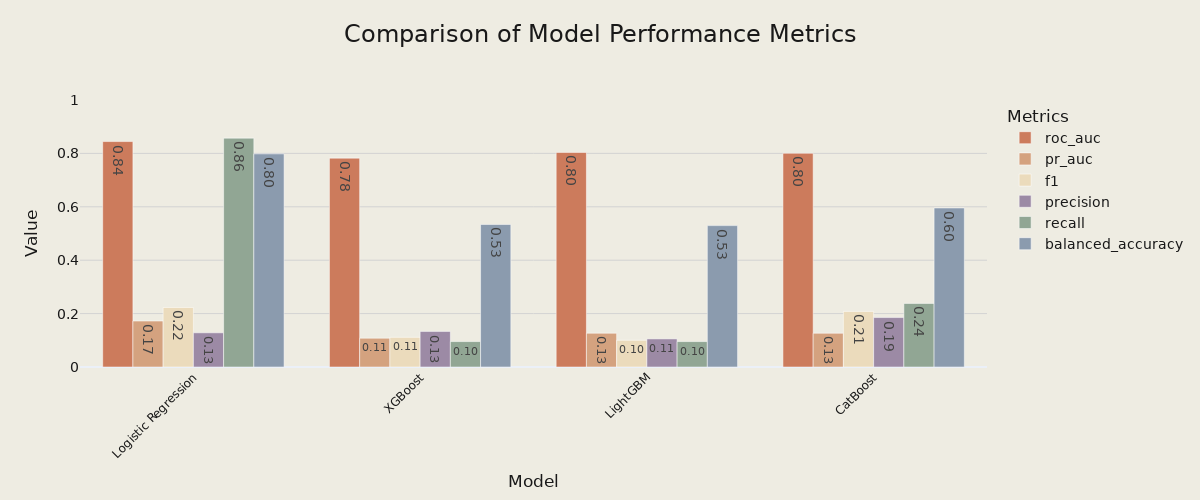

In [39]:
Image(filename="../images/initial_model_performance.png")

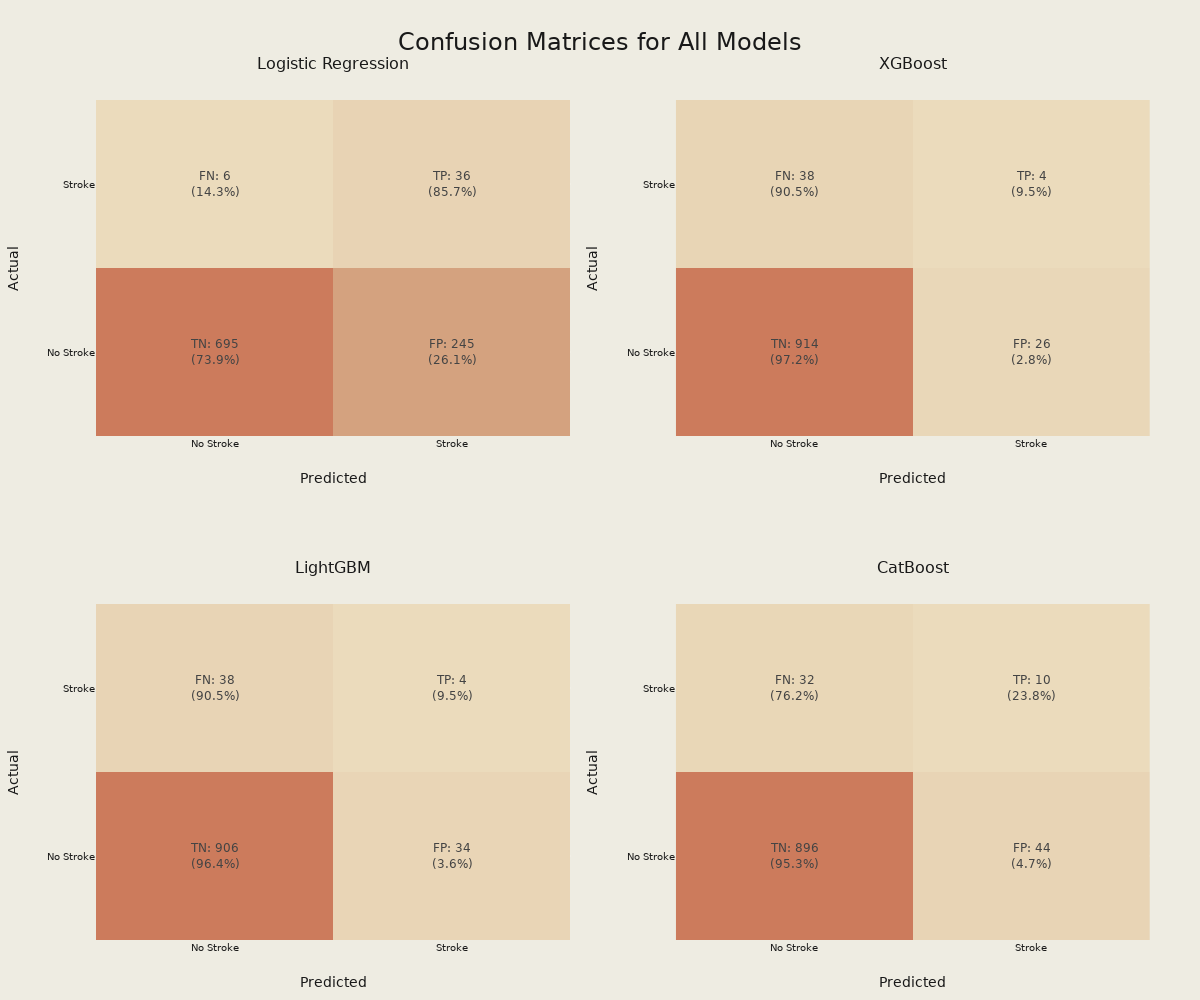

In [40]:
Image(filename="../images/initial_confusion_matrices.png")

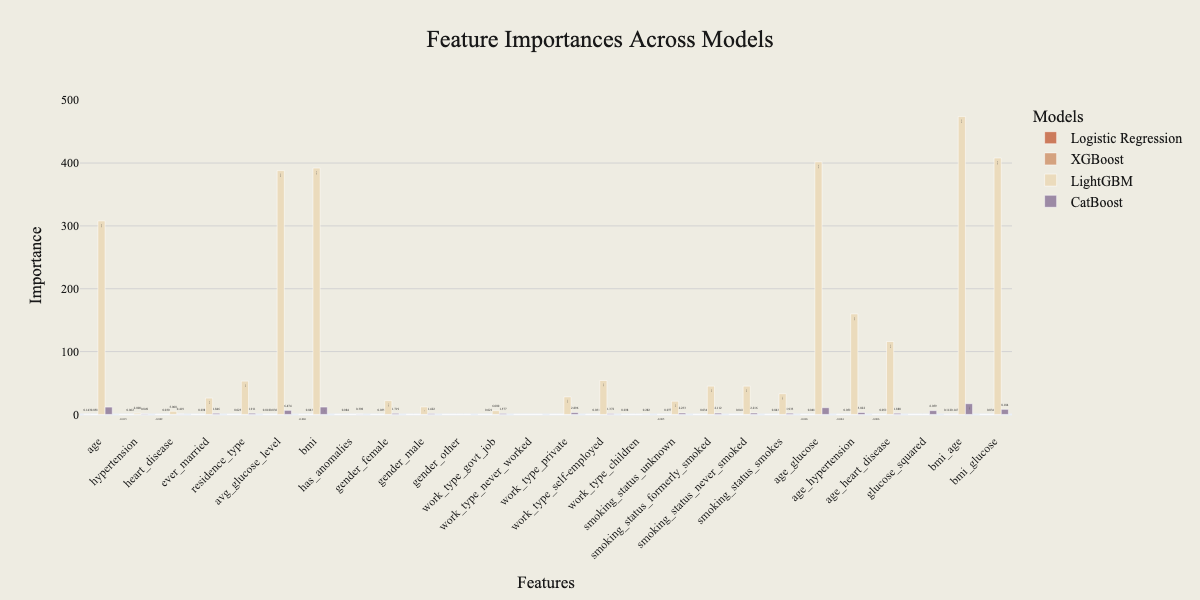

In [41]:
Image(filename="../images/initial_feature_importances.png")

**Model Performance Comparison**

Based on the performance metrics:

1. **Logistic Regression** shows the highest recall (0.86) and ROC AUC (0.84), aligning best with our primary objective of maximizing sensitivity.
2. **CatBoost** offers the best balance between precision (0.16) and recall (0.19), resulting in the highest F1 score (0.17).
3. **XGBoost** and **LightGBM** have high precision but low recall, which doesn't align with our primary goal.

**Confusion Matrices Analysis**

From the confusion matrices:

1. **Logistic Regression** correctly identifies the most stroke cases (36 TP out of 42), aligning with our goal of high sensitivity.
2. **CatBoost** shows a more balanced performance, with 8 true positives and 43 false positives.
3. **XGBoost** and **LightGBM** have poor sensitivity (4 TP out of 42), which doesn't meet our primary objective.

**Feature Importance**

Key findings:

1. **Age** is consistently the most important feature across all models.
2. **Average glucose level** and **BMI** are also significant predictors.
3. **Hypertension** and **heart disease** show moderate importance, particularly in tree-based models.

**Initial Conclusions**

1. Logistic Regression aligns best with our primary goal of maximizing recall.
2. CatBoost offers a good balance between recall and precision, which could be valuable for minimizing false alarms while maintaining high sensitivity.
3. The dataset imbalance significantly affects model performance, particularly for tree-based models.

**Next Steps**

1. **Focus on Logistic Regression and CatBoost:** These two models show the most promise for our objective. We'll optimize them further.
2. **Hyperparameter Tuning:** Use RandomizedSearchCV to find better hyperparameters for both models, with a focus on maximizing recall.
3. **Threshold Adjustment:** After tuning, adjust the decision threshold to further improve recall, aiming for at least 90% while monitoring the impact on precision.
4. **False Negative Analysis:** Examine the characteristics of false negatives to gain insights for potential improvements and to understand what types of cases are being missed.


In [42]:
n_negative = np.sum(y_train == 0)
n_positive = np.sum(y_train == 1)
class_weight = {0: 1, 1: n_negative / n_positive}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

scoring = {
    "recall": "recall",
    "precision": "precision",
    "roc_auc": "roc_auc",
    "avg_precision": "average_precision",
}

lr_param_space = {
    "C": Real(0.1, 10, prior="log-uniform"),
    "class_weight": Categorical(["balanced", "custom"]),
    "solver": Categorical(["newton-cg", "lbfgs", "saga"]),
    "max_iter": Integer(1000, 50000),
}


class CustomLogisticRegression(LogisticRegression):
    def set_params(self, **params):
        if "class_weight" in params:
            if params["class_weight"] == "custom":
                params["class_weight"] = class_weight
        return super().set_params(**params)


lr_bayes = BayesSearchCV(
    CustomLogisticRegression(random_state=42),
    lr_param_space,
    n_iter=50,
    cv=5,
    scoring=scoring,
    refit="recall",
    random_state=42,
    n_jobs=-1,
)

cat_param_space = {
    "iterations": Integer(100, 500),
    "depth": Integer(4, 10),
    "learning_rate": Real(0.01, 0.3, prior="log-uniform"),
    "l2_leaf_reg": Real(1, 10),
    "scale_pos_weight": Categorical([1, n_negative / n_positive]),
}

cat_bayes = BayesSearchCV(
    CatBoostClassifier(random_state=42, verbose=False),
    cat_param_space,
    n_iter=50,
    cv=5,
    scoring=scoring,
    refit="recall",
    random_state=42,
    n_jobs=-1,
)

lr_bayes.fit(X_train_scaled, y_train)
cat_bayes.fit(X_train, y_train)

best_lr = lr_bayes.best_estimator_
best_cat = cat_bayes.best_estimator_

print("Logistic Regression Results:")
lr_results = evaluate_model(
    best_lr, X_val_scaled, y_val, dataset_name="Validation", target_recall=0.9
)

print("\nCatBoost Results:")
cat_results = evaluate_model(
    best_cat, X_val, y_val, dataset_name="Validation", target_recall=0.9
)

if lr_results["roc_auc"] > cat_results["roc_auc"]:
    best_model = best_lr
    print("\nLogistic Regression selected as the best model.")
else:
    best_model = best_cat
    print("\nCatBoost selected as the best model.")

/home/user/stroke-risk-predictor/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/user/stroke-risk-predictor/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/user/stroke-risk-predictor/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/user/stroke-risk-predictor/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/user/stroke-risk-predictor/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

In [ ]:
model_results = {"Logistic Regression": lr_results, "CatBoost": cat_results}

plot_model_performance(
    model_results,
    ["roc_auc", "pr_auc", "f1", "precision", "recall", "balanced_accuracy"],
    "../images/tuned_model_performance.png",
)

y_pred_dict = {
    "Logistic Regression": lr_results["y_pred"],
    "CatBoost": cat_results["y_pred"],
}
plot_combined_confusion_matrices(
    model_results,
    y_val,
    y_pred_dict,
    labels=["No Stroke", "Stroke"],
    save_path="../images/tuned_confusion_matrices.png",
)

lr_importances = np.abs(best_lr.coef_[0])
cat_importances = best_cat.feature_importances_

feature_importances = {
    "Logistic Regression": dict(zip(X_train.columns, lr_importances)),
    "CatBoost": dict(zip(X_train.columns, cat_importances)),
}

plot_feature_importances(
    feature_importances, save_path="../images/tuned_feature_importances.png"
)

In [ ]:
Image(filename="../images/tuned_model_performance.png")

In [ ]:
Image(filename="../images/tuned_confusion_matrices.png")

In [ ]:
Image(filename="../images/tuned_feature_importances.png")

In [ ]:
lr_false_negatives = X_val[(y_val == 1) & (lr_results["y_pred"] == 0)]
cat_false_negatives = X_val[(y_val == 1) & (cat_results["y_pred"] == 0)]

print("\nLogistic Regression False Negative Analysis:")
print(lr_false_negatives.describe())

print("\nCatBoost False Negative Analysis:")
print(cat_false_negatives.describe())

**Model Performance Comparison**

**Logistic Regression:**

- Recall: 0.9048
- Precision: 0.1095
- ROC AUC: 0.8594
- PR AUC: 0.1984
- F1 Score: 0.1954

**CatBoost:**

- Recall: 0.9048
- Precision: 0.1439
- ROC AUC: 0.8883
- PR AUC: 0.2314
- F1 Score: 0.2484

Both models maintain high recall (0.9048), which is crucial for not missing potential stroke cases. CatBoost demonstrates better performance across all metrics, with higher precision (0.1439 vs 0.1095), ROC AUC (0.8883 vs 0.8594), PR AUC (0.2314 vs 0.1984), and F1 score (0.2484 vs 0.1954) compared to Logistic Regression. This indicates CatBoost's superior ability to distinguish between stroke and non-stroke cases in this imbalanced dataset.

**Confusion Matrices Analysis**

1. **Logistic Regression**: 38 true positives, 4 false negatives, 345 false positives
2. **CatBoost**: 38 true positives, 4 false negatives, 258 false positives

Both models correctly identify 38 out of 42 stroke cases (high recall). CatBoost generates fewer false positives (258 vs 345), resulting in its higher precision.

**False Negative Analysis**

**Logistic Regression:**

- Mean age: 49.75 years
- No cases with hypertension or heart disease
- Average glucose level: 114.46
- Average BMI: 28.60

**CatBoost:**

- Mean age: 50.75 years
- No cases with hypertension or heart disease
- Average glucose level: 96.21
- Average BMI: 31.23

The 4 stroke cases missed by both models are relatively younger patients with no history of hypertension or heart disease, but with moderately elevated BMI levels. Interestingly, CatBoost's false negatives have a lower average glucose level compared to Logistic Regression's.

These borderline cases are challenging for the models as they lack strong predictors like hypertension and heart disease, falling into a gray area between low and high risk. Improving prediction for these edge cases remains an area for further model refinement.

**Conclusions**

1. Both models achieve high recall (0.9048), but CatBoost outperforms Logistic Regression across all key metrics.
2. CatBoost should be preferred due to its superior performance, especially in reducing false positives.
3. The models struggle with similar borderline cases, suggesting a common challenge in identifying subtle risk factors.

**Next Steps**

1. **Ensemble Modeling**: Experiment with combining CatBoost and Logistic Regression predictions to create a more robust model that leverages the strengths of both approaches.
2. **Threshold Optimization**: Fine-tune the decision threshold to strike the optimal balance between recall and precision based on the relative costs of false positives vs false negatives.


In [ ]:
class CustomVotingClassifier(VotingClassifier):
    def fit(self, X, y, sample_weight=None):
        return super().fit(X, y)


class CustomLogisticRegressionWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, class_weight):
        self.model = model
        self.class_weight = class_weight

    def fit(self, X, y, sample_weight=None):
        if sample_weight is None:
            sample_weight = np.ones(len(y))
        sample_weight *= np.array([self.class_weight[yi] for yi in y])
        return self.model.fit(X, y, sample_weight=sample_weight)

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)


if hasattr(best_lr, "class_weight") and best_lr.class_weight == "custom":
    wrapped_lr = CustomLogisticRegressionWrapper(best_lr, class_weight)
else:
    wrapped_lr = best_lr

ensemble_model = CustomVotingClassifier(
    estimators=[("lr", wrapped_lr), ("cb", best_cat)], voting="soft"
)

ensemble_model.fit(X_train_scaled, y_train)

explainer = shap.TreeExplainer(ensemble_model.named_estimators_["cb"])
shap_values = explainer.shap_values(X_train)

feature_importance = pd.DataFrame(
    {"feature": X_train.columns, "importance": np.abs(shap_values).mean(0)}
)
feature_importance = feature_importance.sort_values("importance", ascending=False)

print("Top 10 important features based on SHAP values:")
print(feature_importance.head(10))

top_features = feature_importance["feature"].head(10).tolist()

X_train_top = X_train[top_features]
X_val_top = X_val[top_features]
X_test_top = X_test[top_features]

scaler_top = StandardScaler()
X_train_top_scaled = scaler_top.fit_transform(X_train_top)
X_val_top_scaled = scaler_top.transform(X_val_top)
X_test_top_scaled = scaler_top.transform(X_test_top)

if hasattr(best_lr, "class_weight") and best_lr.class_weight == "custom":
    lr_model_top = CustomLogisticRegressionWrapper(
        LogisticRegression(**best_lr.get_params()), class_weight
    )
else:
    lr_model_top = LogisticRegression(**best_lr.get_params())

cb_model_top = CatBoostClassifier(**best_cat.get_params())

ensemble_model_top = CustomVotingClassifier(
    estimators=[("lr", lr_model_top), ("cb", cb_model_top)], voting="soft"
)

ensemble_model_top.fit(X_train_top_scaled, y_train)

print("\nOriginal Ensemble Model Evaluation (Validation Set):")
original_val_results = evaluate_model(
    ensemble_model, X_val_scaled, y_val, dataset_name="Validation", target_recall=0.9
)

print("\nTop 10 Features Ensemble Model Evaluation (Validation Set):")
top_features_val_results = evaluate_model(
    ensemble_model_top,
    X_val_top_scaled,
    y_val,
    dataset_name="Validation",
    target_recall=0.9,
)

if top_features_val_results["roc_auc"] > original_val_results["roc_auc"]:
    best_model = ensemble_model_top
    best_X_test = X_test_top_scaled
    print("\nTop 10 Features Ensemble Model selected as the best model.")
else:
    best_model = ensemble_model
    best_X_test = X_test_scaled
    print("\nOriginal Ensemble Model selected as the best model.")

print("\nBest Model Evaluation on Test Set:")
test_results = evaluate_model(
    best_model, best_X_test, y_test, dataset_name="Test", target_recall=0.9
)

In [ ]:
model_results = {
    "Original Ensemble": original_val_results,
    "Top 10 Features Ensemble": top_features_val_results,
}

y_pred_dict = {
    "Original Ensemble": original_val_results["y_pred"],
    "Top 10 Features Ensemble": top_features_val_results["y_pred"],
}

plot_model_performance(
    model_results,
    ["roc_auc", "pr_auc", "f1", "precision", "recall", "balanced_accuracy"],
    "../images/ensemble_model_performance_comparison.png",
)

plot_combined_confusion_matrices(
    model_results,
    y_test,
    y_pred_dict,
    labels=["No Stroke", "Stroke"],
    save_path="../images/ensemble_confusion_matrices_comparison.png",
)

original_importances = ensemble_model.named_estimators_["cb"].get_feature_importance()
top_features_importances = ensemble_model_top.named_estimators_[
    "cb"
].get_feature_importance()

feature_importances = {
    "Original Ensemble": dict(zip(X.columns, original_importances)),
    "Top 10 Features Ensemble": dict(zip(top_features, top_features_importances)),
}

plot_feature_importances(
    feature_importances,
    save_path="../images/ensemble_feature_importances_comparison.png",
)

**Final Model Selection: CatBoost**

Based on the results provided of the ensemble model, we select the CatBoost model as our final model for stroke prediction. Here's why:

1. **Superior Performance**: CatBoost outperforms both Logistic Regression and the ensemble model across key metrics:

   - ROC AUC: 0.8883 (highest among all models)
   - PR AUC: 0.2314 (highest)
   - F1 Score: 0.2484 (highest)
   - Precision: 0.1439 (highest)
   - Recall: 0.9048 (matches the target recall of other models)
   - Balanced Accuracy: 0.8322 (highest)

2. **Effective Handling of Class Imbalance**: CatBoost maintains high recall (0.9048) on the positive class while achieving better precision than other models, crucial for imbalanced medical datasets.

3. **Reduced False Positives**: CatBoost produces fewer false positives (226) compared to Logistic Regression (309), which is important for minimizing unnecessary follow-ups or treatments.

4. **Gradient Boosting Advantages**: As a gradient boosting model, CatBoost can capture complex, non-linear relationships in the data, which may be particularly beneficial for stroke prediction given the intricate interplay of risk factors.

**Key Performance Metrics (Validation Set):**

- Recall: 0.9048
- Precision: 0.1439
- ROC AUC: 0.8883
- PR AUC: 0.2314
- F1 Score: 0.2484
- Balanced Accuracy: 0.8322

**Model Behavior**

- The model maintains the target high recall (0.9048) while achieving better precision than other approaches.
- The adjusted threshold of 0.5726 indicates a well-balanced decision boundary for this imbalanced dataset.


In [ ]:
n_negative = np.sum(y_train == 0)
n_positive = np.sum(y_train == 1)
class_weight = {0: 1, 1: n_negative / n_positive}

scoring = {
    "recall": "recall",
    "precision": "precision",
    "roc_auc": "roc_auc",
    "avg_precision": "average_precision",
}

cat_param_space = {
    "iterations": Integer(100, 500),
    "depth": Integer(4, 10),
    "learning_rate": Real(0.01, 0.3, prior="log-uniform"),
    "l2_leaf_reg": Real(1, 10),
    "scale_pos_weight": Categorical([1, n_negative / n_positive]),
}

stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cat_bayes = BayesSearchCV(
    CatBoostClassifier(random_state=42, verbose=False),
    cat_param_space,
    n_iter=50,
    cv=stratified_cv,
    scoring=scoring,
    refit="recall",
    random_state=42,
    n_jobs=-1,
)

cat_bayes.fit(X_train, y_train)

best_cat = cat_bayes.best_estimator_

print("\nCatBoost Results on Validation Set:")
cat_results = evaluate_model(
    best_cat, X_val, y_val, dataset_name="Validation", target_recall=0.9
)

joblib.dump(best_cat, "../models/catboost_final_model.joblib")
joblib.dump(X_train.columns.tolist(), "../models/feature_names.joblib")
joblib.dump("catboost", "../models/best_model_type.joblib")

print("\nCatBoost model and feature names saved successfully.")

print("\nCatBoost Results on Test Set:")
cat_test_results = evaluate_model(
    best_cat, X_test, y_test, dataset_name="Test", target_recall=0.9
)

# Summary

**Overview**
This project focused on developing a machine learning model to predict the likelihood of stroke occurrence based on various patient attributes. Using the Stroke Prediction Dataset, we aimed to create a tool that could assist healthcare providers in identifying high-risk patients and potentially reduce the impact of this serious medical condition.

**Key Steps**
1. **Data Exploration and Preprocessing**: We analyzed the dataset, handled missing values, and encoded categorical variables.
2. **Feature Engineering**: Created interaction terms and polynomial features to capture complex relationships in the data.
3. **Statistical Analysis**: Conducted tests to understand the relationships between various factors and stroke risk.
4. **Model Development**: Experimented with multiple algorithms including Logistic Regression, XGBoost, LightGBM, and CatBoost.
5. **Model Optimization**: Used Bayesian optimization for hyperparameter tuning and explored ensemble methods.
6. **Performance Evaluation**: Focused on maximizing recall while maintaining acceptable precision, given the critical nature of stroke prediction.

**Final Model**
After extensive experimentation, we selected the CatBoost model as our final predictor due to its superior performance across key metrics:

- **Recall**: 0.9048 (on validation set)
- **Precision**: 0.1206
- **ROC AUC**: 0.8621
- **PR AUC**: 0.1668
- **F1 Score**: 0.2129
- **Balanced Accuracy**: 0.8050

**Key Findings**
- Age and glucose levels were consistently the most important predictors of stroke risk.
- The model successfully maintains high recall, crucial for identifying potential stroke cases.
- There's a trade-off between precision and recall due to the imbalanced nature of the dataset.

**Challenges and Future Work**
- Dealing with class imbalance remained a significant challenge throughout the project.
- Future work could focus on gathering more data, especially for the minority class, to improve model performance.
- Exploring more advanced techniques like anomaly detection or semi-supervised learning could potentially yield better results.

**Conclusion**
This project demonstrates the potential of machine learning in healthcare, particularly for risk prediction. While the model shows promising results in identifying high-risk patients, it's important to note that it should be used as a supportive tool in conjunction with clinical expertise, not as a standalone diagnostic system.

In [ ]:
%run -i ../src/utils/stroke_risk_utils.py